In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy as stats


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# filepath = "/content/drive/My Drive/Multi/"
# fraud = pd.read_csv(filepath + "Fraud_Data.csv")
# ip = pd.read_csv(filepath + "IpAddress_to_Country.csv")


In [0]:
# fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [0]:
# ip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
lower_bound_ip_address    138846 non-null float64
upper_bound_ip_address    138846 non-null int64
country                   138846 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [0]:
# merge = fraud.to_csv (filepath+"fraud_merge_country.csv", index = None, header=True)

In [7]:
filepath = "/content/drive/My Drive/Multi/"
fraud_merge = pd.read_csv(filepath +"fraud_merge_country.csv")
fraud_merge.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


## Exploratory analysis & Feature Engineering

In [0]:
for col in ['signup_time','purchase_time']:
  fraud_merge[col] = pd.to_datetime(fraud_merge[col])

We can notice that dataset includes records in year 2015.

In [20]:
def from_to(col,df):
  print(col,":")
  print('From:%s' % df[col].min())
  print('To:%s' % df[col].max())


from_to('purchase_time',fraud_merge)
from_to('signup_time',fraud_merge)

purchase_time :
From:2015-01-01 00:00:44
To:2015-12-16 02:56:05
signup_time :
From:2015-01-01 00:00:42
To:2015-08-18 04:40:29


Deal with time variables:
* 1.group the time as day, week, month
* 2.create a new variable as time difference between signup and purchase


In [0]:
def time_convert(col):
    fraud_merge[col[:-5]+ "_" + 'month'] = fraud_merge[col].dt.month
    fraud_merge[col[:-5]+ "_" + 'weekofyear'] = fraud_merge[col].dt.weekofyear
    0fraud_merge[col[:-5]+ "_" + 'weekday'] = fraud_merge[col].dt.weekday

for col in ['signup_time','purchase_time']:
  time_convert(col)

In [0]:
fraud_merge['signTOpurchase'] = (fraud_merge['purchase_time']-fraud_merge['signup_time']).dt.total_seconds()

In [0]:
timelist = [ 'signup_time','purchase_time', 'signup_month', 'signup_weekofyear', 
            'signup_weekday', 'purchase_month', 'purchase_weekofyear', 'purchase_weekday']

numlist = ['purchase_value', 'age','signTOpurchase']

catlist = [col for col in fraud_merge.columns if col not in (timelist+numlist)]


In [55]:
fraud_merge[numlist].describe()

,purchase_value,age,signTOpurchase
count,151112.000000,151112.000000,1.511120e+05
mean,36.935372,33.140704,4.932029e+06
std,18.322762,8.617733,3.126263e+06
min,9.000000,18.000000,1.000000e+00
25%,22.000000,27.000000,2.186754e+06
50%,35.000000,33.000000,4.926346e+06
75%,49.000000,39.000000,7.644525e+06
max,154.000000,76.000000,1.036797e+07


## Outliers Check
* it seems all these variables are not hugely affected by outliers, also we want it to be sensitive when detecting fraud, extreme values will be important to, so we will not delete outliers here.

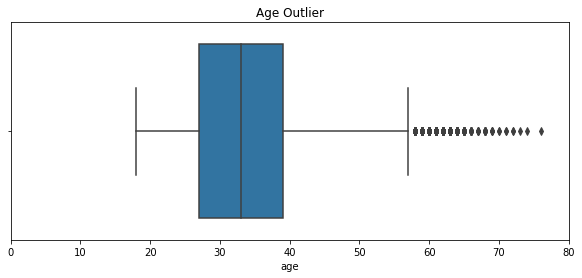

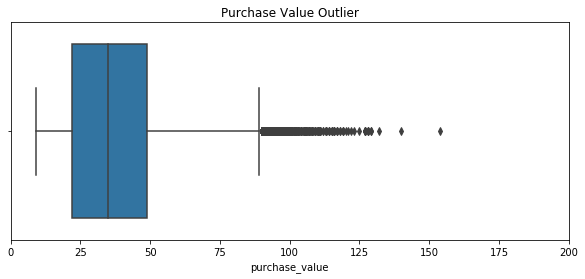

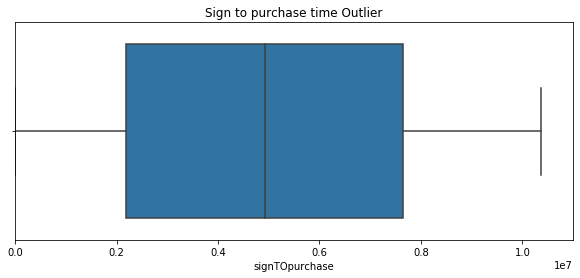

In [83]:

plt.figure(figsize=(10,4))
plt.xlim(0, 80)
plt.title("Age Outlier")
sns.boxplot(x=fraud_merge['age'])


plt.figure(figsize=(10,4))
plt.xlim(0, 200)
plt.title("Purchase Value Outlier")
sns.boxplot(x=fraud_merge['purchase_value'])



plt.figure(figsize=(10,4))
plt.title("Sign to purchase time Outlier")
plt.xlim(0, 1.1e+07)
sns.boxplot(x=fraud_merge['signTOpurchase'])



#### we can find devices and ip are shared
* n of user id != n of device
* n of user id != n of ip_address

#### Thus, we can create new features including the times they are shared, which can be suspicious if more is shared

#### we can notice that we have in total 182 countries, the less visit from a country can be more suspicious

In [56]:
fraud_merge[catlist].nunique() 

user_id       151112
device_id     137956
source             3
browser            5
sex                2
ip_address    143512
class              2
country          182
dtype: int64

In [0]:
# deal with shared devices and ip
device_shared = fraud_merge.device_id.value_counts()
ip_shared = fraud_merge.ip_address.value_counts()
fraud_merge ['device_shared'] = fraud_merge.device_id.map(device_shared)
fraud_merge['ip_shared']= fraud_merge.ip_address.map(ip_shared)

# deal with country
country_shared = fraud_merge.country.value_counts()
fraud_merge['country_shared'] = fraud_merge.country.map(country_shared)


In [0]:
for col in ['device_shared','ip_shared','country_shared']:
  numlist.append(col)

In [74]:
for col in ['source', 'browser', 'sex', 'class']:
    print(fraud_merge[col].unique())
    print(fraud_merge[col].value_counts())

['SEO' 'Ads' 'Direct']
SEO       60615
Ads       59881
Direct    30616
Name: source, dtype: int64
['Chrome' 'Opera' 'Safari' 'IE' 'FireFox']
Chrome     61432
IE         36727
Safari     24667
FireFox    24610
Opera       3676
Name: browser, dtype: int64
['M' 'F']
M    88293
F    62819
Name: sex, dtype: int64
[0 1]
0    136961
1     14151
Name: class, dtype: int64


### Check if dataset is balanced

* dataset is not balanced, we can consider oversample to rebalance it

In [92]:
print('Fraud rate is {:.3f}%'.format(np.mean(fraud_merge['class'])*100))

Fraud rate is 9.365%


### Regular distribution without bootstrap


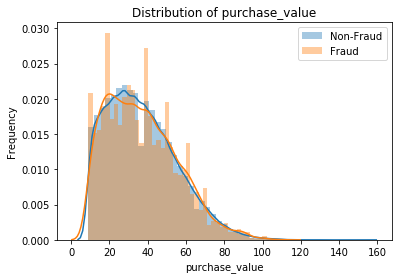

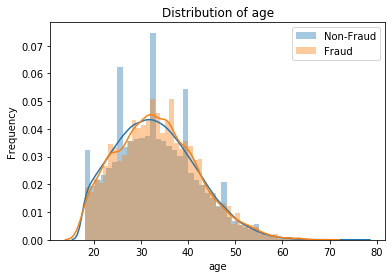

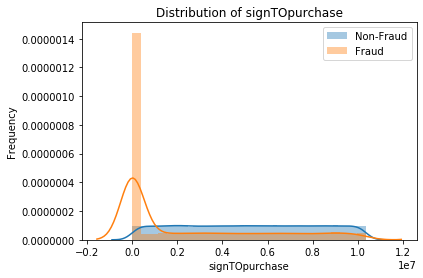

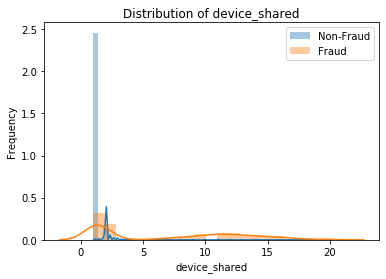

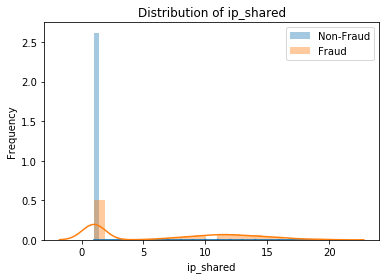

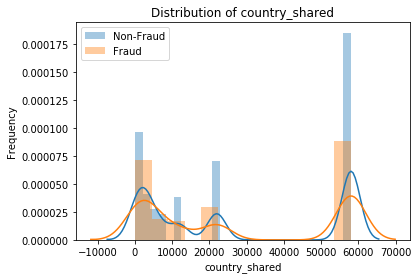

In [107]:
fraud = fraud_merge[fraud_merge['class'] == 1].copy()
non_fraud = fraud_merge[fraud_merge['class'] == 0].copy()
for col in numlist:
    # Plot the samples
    sns.distplot(non_fraud[col], label='Non-Fraud')
    sns.distplot(fraud[col], label='Fraud')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Distribution of {}'.format(col))
    plt.legend()
    plt.show()

Bootstrap distribution

In [0]:
# Define a function for bootstrapping
def bootstrap_mean(cat, num):
    non_fraud_bootstrap = np.empty(num)
    fraud_bootstrap = np.empty(num)

    for i in range(num):
        non_fraud_bootstrap[i] = np.mean(np.random.choice(non_fraud[cat], len(non_fraud)))
        fraud_bootstrap[i] = np.mean(np.random.choice(fraud[cat], len(fraud)))
        
    return non_fraud_bootstrap, fraud_bootstrap

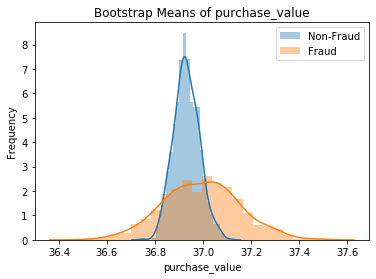

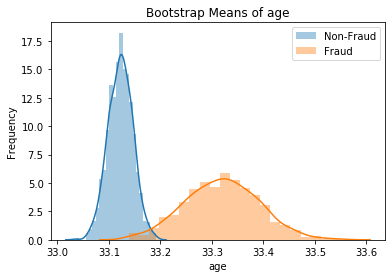

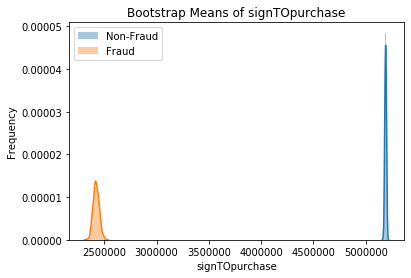

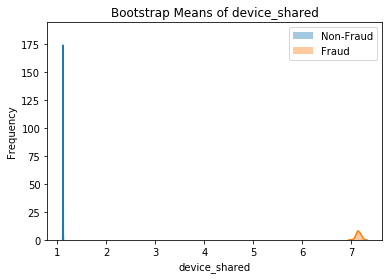

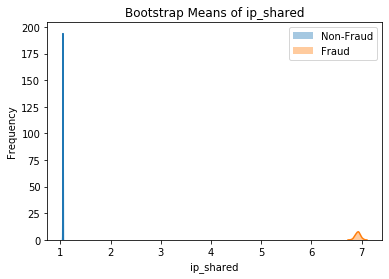

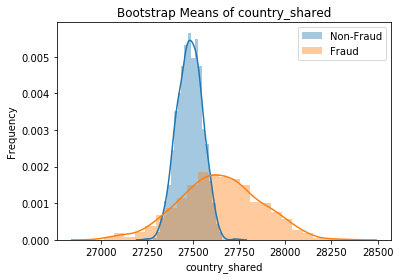

In [109]:
for col in numlist:
    
    # Define 1000 bootstrap samples for each category
    non_fraud_repl, fraud_repl = bootstrap_mean(col, 1000)

    # Plot the samples
    sns.distplot(non_fraud_repl, label='Non-Fraud')
    sns.distplot(fraud_repl, label='Fraud')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title('Bootstrap Means of {}'.format(col))
    plt.legend()
    plt.show()


## Key Findings for numerical variables:
* Sign to purchase time: sign to purchase time seems to be a strong impact variable since it appears that fraud tends to happen when purchase is made within 24 hours of the sign up.

* Age: It seems that fraudulent activities have a higher frequency around age 31 - 33

* purchase value: It seems that purchase value dose not impact it so much.

* IP shared: IP shared more times, the more likely the activity is fruadulent (near 7 is high risky)

* Device shared: Device shared more times, the more likely it is fruadulent activity(near 7 is high risky).

* Country shared(visited times from a country): The less visit from a country, the more likely purchase from this country is fruad.



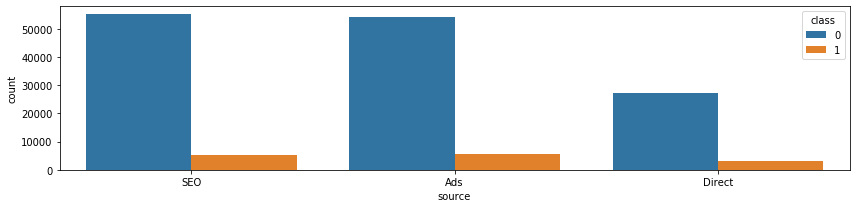

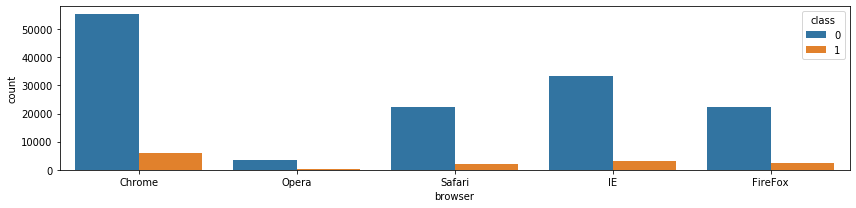

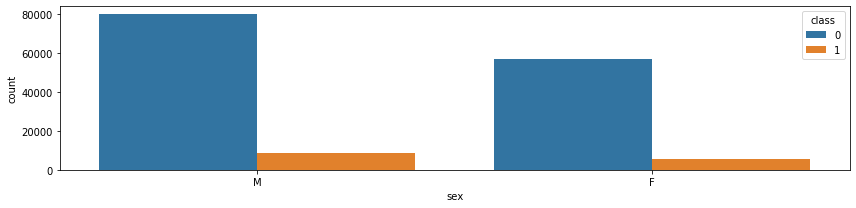

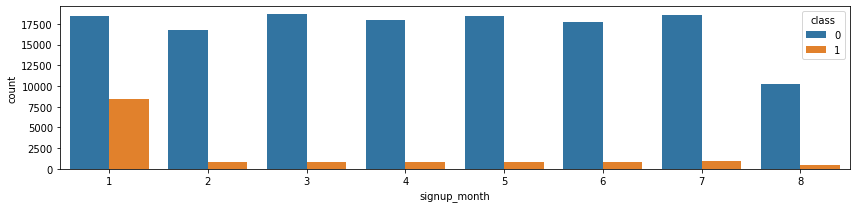

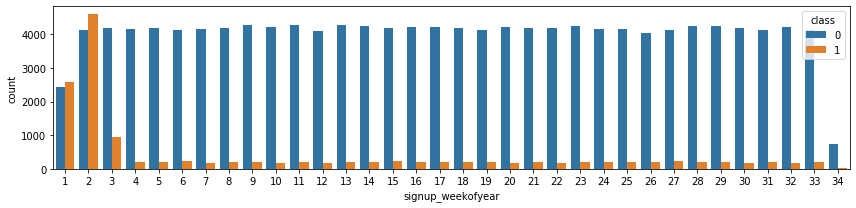

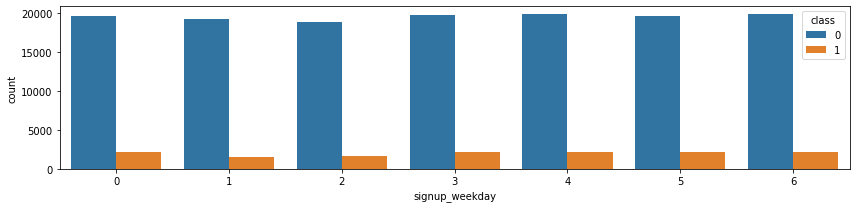

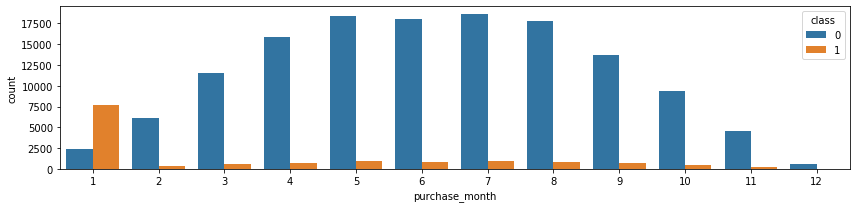

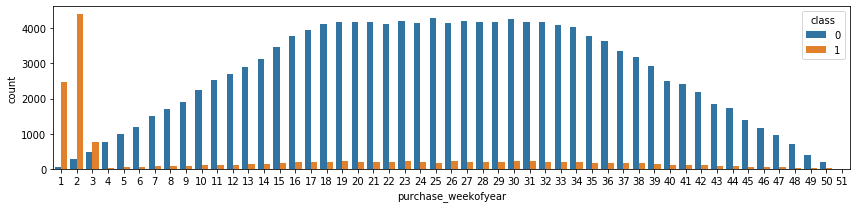

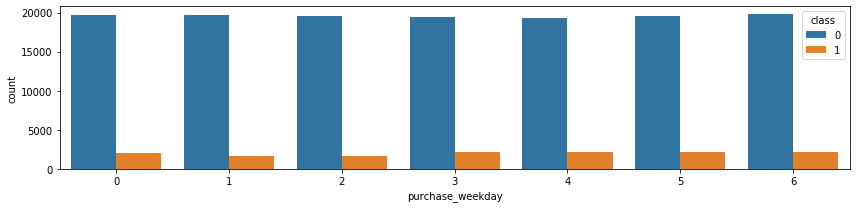

In [130]:
timelist_1 = [i for i in timelist if i not in ['signup_time','purchase_time']]


for col in ['source', 'browser', 'sex'] + timelist_1:
    plt.figure(figsize=(12,3))
    sns.countplot(x=col, hue='class', data=fraud_merge)
    plt.tight_layout()


Key Findings for Categorical variables:
* SEO and Ads have higher frequency of fraud.
* It seems that fraudulent activities occur most during January(The first 3 weeks and espically high in Feb), we keep weekofyear as our time varaible while deleting day of year and month.
* Chrome has the most fraud activity